# Garbage Classification Using Transfer Learning
---------------
Developer : Shanmugaraj

# 1 - Importing Libraries

In [2]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

# 2 - Loading Data

In [3]:
#Loading Dataset
dataset_dir= r"C:\Users\USER\OneDrive\Documents\GitHub\Week-1\garbage\TrashType_Image_Dataset"

image_size = (224, 224)
batch_size = 32
seed = 42

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Get class names from validation dataset
val_class = val_ds.class_names

# Split validation into test and validation sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# ✨ Pretty output section
print("\nDataset Summary")
print("-" * 30)

print("Class Names:")
for i, cls in enumerate(train_ds.class_names, 1):
    print(f"  {i}. {cls}")

print(f"\nTotal Classes     : {len(train_ds.class_names)}")
print(f"Training Batches  : {len(train_ds)}")
print(f"Validation Batches: {len(val_dat)}")
print(f"Test Batches      : {len(test_ds)}")
print("-" * 30)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

Dataset Summary
------------------------------
Class Names:
  1. cardboard
  2. glass
  3. metal
  4. paper
  5. plastic
  6. trash

Total Classes     : 6
Training Batches  : 64
Validation Batches: 8
Test Batches      : 8
------------------------------


# 3 - Visualizing the Dataset

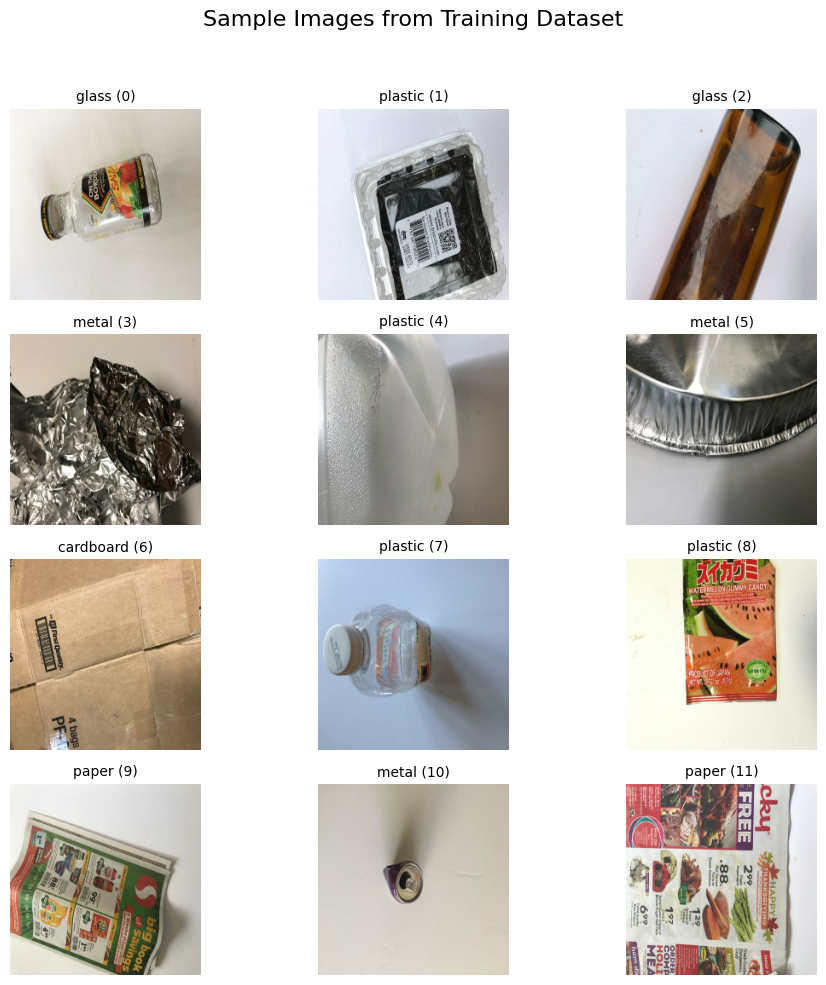

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    num_images = min(len(images), 12)
    for i in range(num_images):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{train_ds.class_names[labels[i]]} ({i})", fontsize=10)
        plt.axis("off")

plt.suptitle("Sample Images from Training Dataset", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust to make space for title
plt.show()


# 4 - Enhanced Class Distribution Visualization


Class Distribution Summary:

    Class  Train (%)  Validation (%)  Test (%)  Overall (%)
cardboard      16.52           13.66     14.06        15.09
    glass      19.73           20.20     17.58        19.96
    metal      15.92           17.43     16.80        16.68
    paper      23.29           24.36     25.00        23.82
  plastic      19.44           17.62     19.14        18.53
    trash       5.09            6.73      7.42         5.91


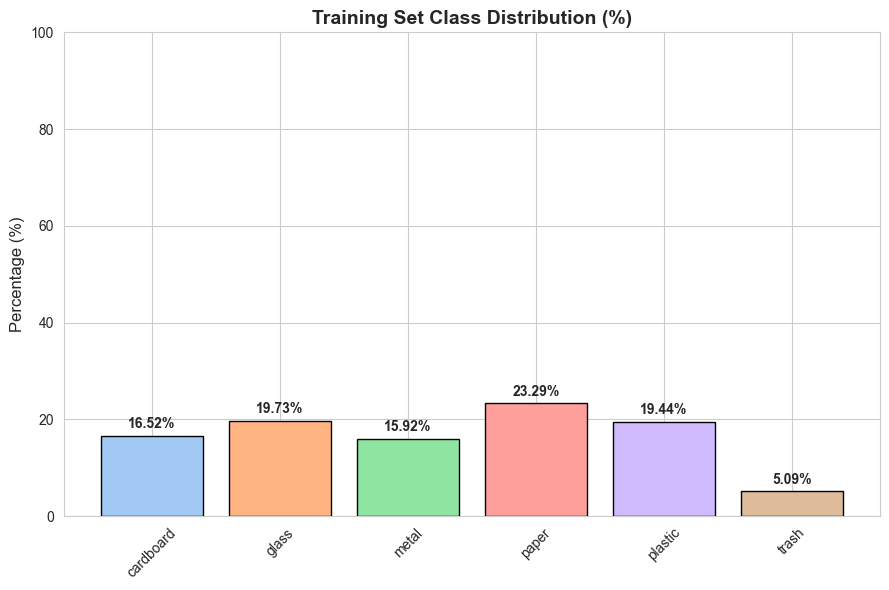

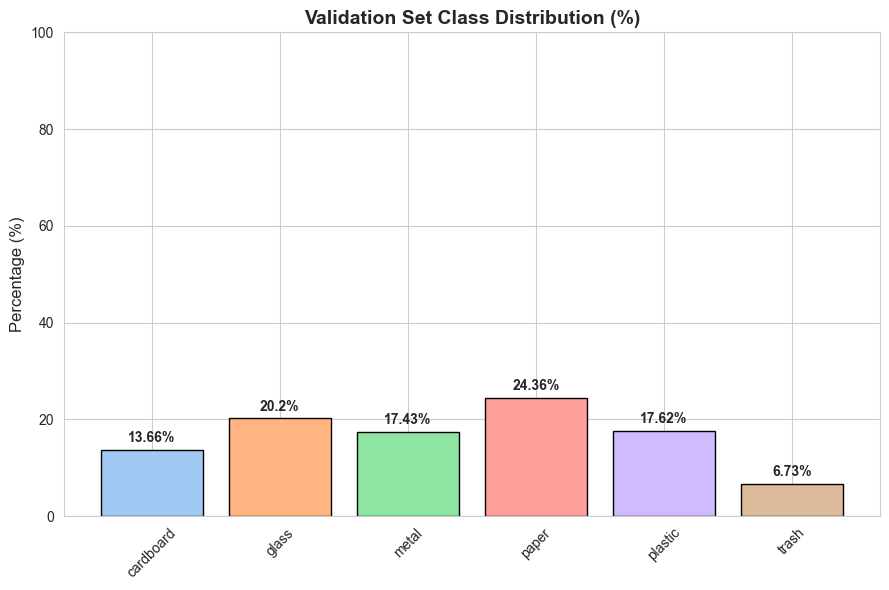

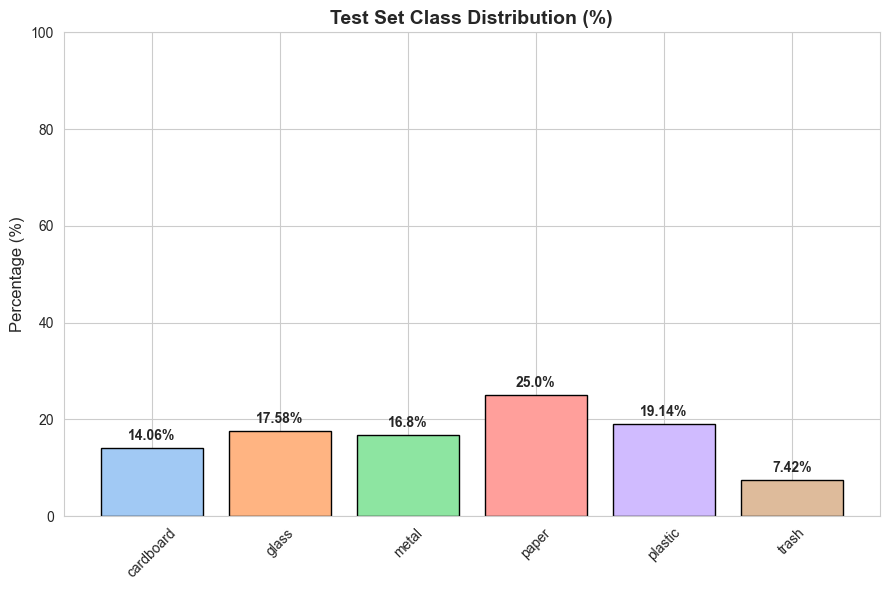

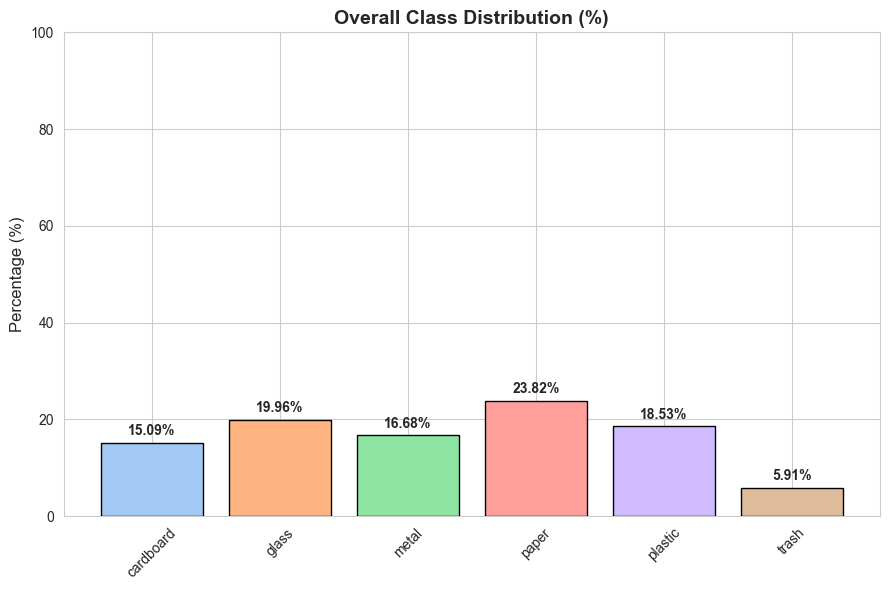

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Function to count class distribution (in %)
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            counts[class_names[label]] += 1
            total += 1

    return {k: round((v / total) * 100, 2) for k, v in counts.items()}

# Improved bar plot function with seaborn
def simple_bar_plot(dist, title):
    plt.figure(figsize=(9, 6))
    sns.set_style("whitegrid")
    
    bars = plt.bar(dist.keys(), dist.values(), color=sns.color_palette("pastel"), edgecolor='black')

    # Add value labels on top
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Get class names
class_names = train_ds.class_names

# Compute distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

# Create DataFrame
dist_df = pd.DataFrame({
    'Class': class_names,
    'Train (%)': [train_dist[k] for k in class_names],
    'Validation (%)': [val_dist[k] for k in class_names],
    'Test (%)': [test_dist[k] for k in class_names],
    'Overall (%)': [overall_dist[k] for k in class_names],
})

# Print clean table
print("\nClass Distribution Summary:\n")
print(dist_df.to_string(index=False))

# Plot distributions
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


# 5 - Calculating Class Weights to Handle Imbalance

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Count class occurrences and collect all labels
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (balanced)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Map class index to weight
class_weights = {i: round(w, 4) for i, w in enumerate(class_weights_array)}

# ✨ Display results nicely
print("\n📊 Class Distribution in Training Set")
print("-" * 40)
for i, name in enumerate(class_names):
    print(f"{i}. {name:<10} ➤ Samples: {class_counts[i]:<4} | Weight: {class_weights[i]}")
print("-" * 40)
print(f"\n🧮 Total Training Samples: {sum(class_counts.values())}")




📊 Class Distribution in Training Set
----------------------------------------
0. cardboard  ➤ Samples: 334  | Weight: 1.009
1. glass      ➤ Samples: 399  | Weight: 0.8446
2. metal      ➤ Samples: 322  | Weight: 1.0466
3. paper      ➤ Samples: 471  | Weight: 0.7155
4. plastic    ➤ Samples: 393  | Weight: 0.8575
5. trash      ➤ Samples: 103  | Weight: 3.2718
----------------------------------------

🧮 Total Training Samples: 2022


# 6 - Preprocessing and Model Training


📦 Starting Model Training...
Epochs       : 15
Class Weights: {0: 1.009, 1: 0.8446, 2: 1.0466, 3: 0.7155, 4: 0.8575, 5: 3.2718}
Checkpoint   : Best model saved to 'best_model224.keras'
Early Stop   : Enabled with patience=3



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3299 - loss: 1.6397
Epoch 1: val_accuracy improved from -inf to 0.69901, saving model to best_model224.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.3321 - loss: 1.6368 - val_accuracy: 0.6990 - val_loss: 0.9806
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7426 - loss: 0.8623
Epoch 2: val_accuracy improved from 0.69901 to 0.85149, saving model to best_model224.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.7428 - loss: 0.8612 - val_accuracy: 0.8515 - val_loss: 0.5415
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8501 - loss: 0.5111
Epoch 3: val_accuracy improved from 0.85149 to 0.88317, saving model to best_model224.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.8503 - loss: 0.5105 - val_accuracy: 0.8832 - val_loss: 0.3743
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9152 - loss: 0.2980
Epoch 4: val_accuracy improved from 0.88317 to 

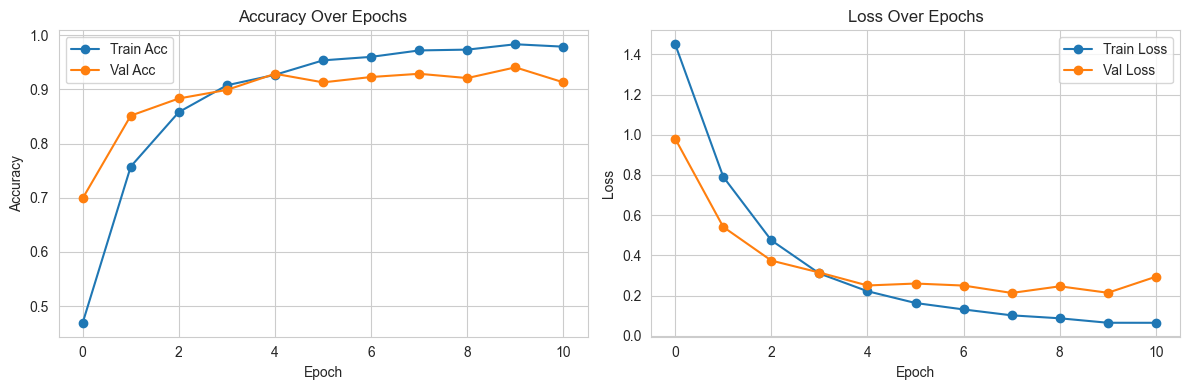

In [11]:
# Unified Model Training Pipeline with 128x128 Image Input and Enhanced Output

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf
import pickle

# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Load Pretrained EfficientNetV2B2 with matching input size
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(224, 224, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build Final Model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model224.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Pre-training Summary
epochs = 15
print("\n📦 Starting Model Training...")
print(f"Epochs       : {epochs}")
print(f"Class Weights: {class_weights}")
print(f"Checkpoint   : Best model saved to 'best_model224.keras'")
print(f"Early Stop   : Enabled with patience=3\n")

# Train the Model with Tqdm progress bar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, checkpoint, TqdmCallback(verbose=1)]
)

# Display training log as a table
df_log = pd.DataFrame(history.history)
print("\n📊 Training Log Summary:")
print(df_log.to_string(index=True))

# Save history for later comparison
with open("history224.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
from tensorflow.keras.models import load_model

model = load_model("best_model224.keras")
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 7, 7, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [13]:
# Find the base model layer by layer name or type
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnetv2b2" in layer.name.lower():
        base_model = layer
        break

# Print summary of the extracted base model
base_model.summary()


Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_1               │ (None, 224, 224, 3)       │               0 │ rescaling_1[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ normalization_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 112, 112, 16)      │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 112, 112, 16)      │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 112, 112, 16)      │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 112, 112, 16)      │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 112, 112, 16)      │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 112, 112, 16)      │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 112, 112, 16)      │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 112, 112, 16)      │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

# 7 - Model Evaluation


Loading Model: best_model224.keras

Evaluating Model on Test Dataset...
--------------------------------------------------
✅ Test Accuracy : 0.9609
📉 Test Loss     : 0.1658
--------------------------------------------------

📊 Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

   cardboard       0.95      1.00      0.97        39
       glass       1.00      0.93      0.96        57
       metal       0.96      1.00      0.98        45
       paper       1.00      0.94      0.97        64
     plastic       0.94      0.94      0.94        33
       trash       0.82      1.00      0.90        18

    accuracy                           0.96       256
   macro avg       0.94      0.97      0.95       256
weighted avg       0.96      0.96      0.96       256

--------------------------------------------------


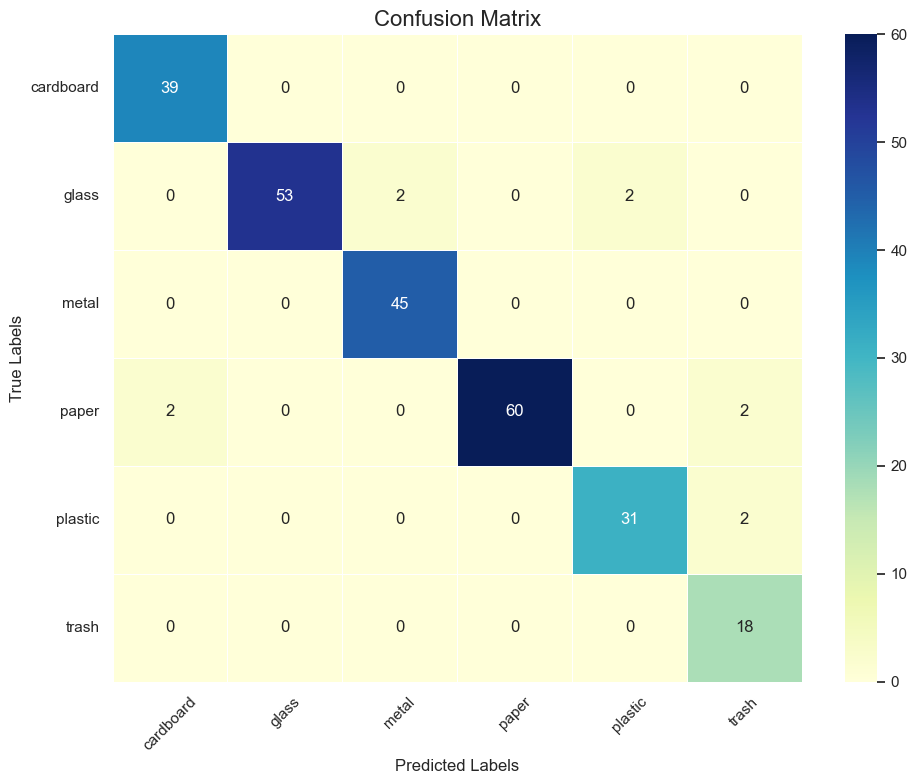

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

def evaluate_model(model_path, test_dataset, class_names):
    # Load the model
    print(f"\nLoading Model: {model_path}")
    model = tf.keras.models.load_model(model_path)

    # Evaluate on test set
    print("\nEvaluating Model on Test Dataset...\n" + "-"*50)
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"✅ Test Accuracy : {accuracy:.4f}")
    print(f"📉 Test Loss     : {loss:.4f}")
    print("-"*50)

    # True and predicted labels
    y_true = np.concatenate([labels.numpy() for _, labels in test_dataset])
    y_pred_probs = model.predict(test_dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print("\n📊 Classification Report:\n" + "-"*50)
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    print("-"*50)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5,
                xticklabels=class_names, yticklabels=class_names)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🧪 Example usage
evaluate_model("best_model224.keras", test_ds_eval, class_names)


# 8 - Final Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


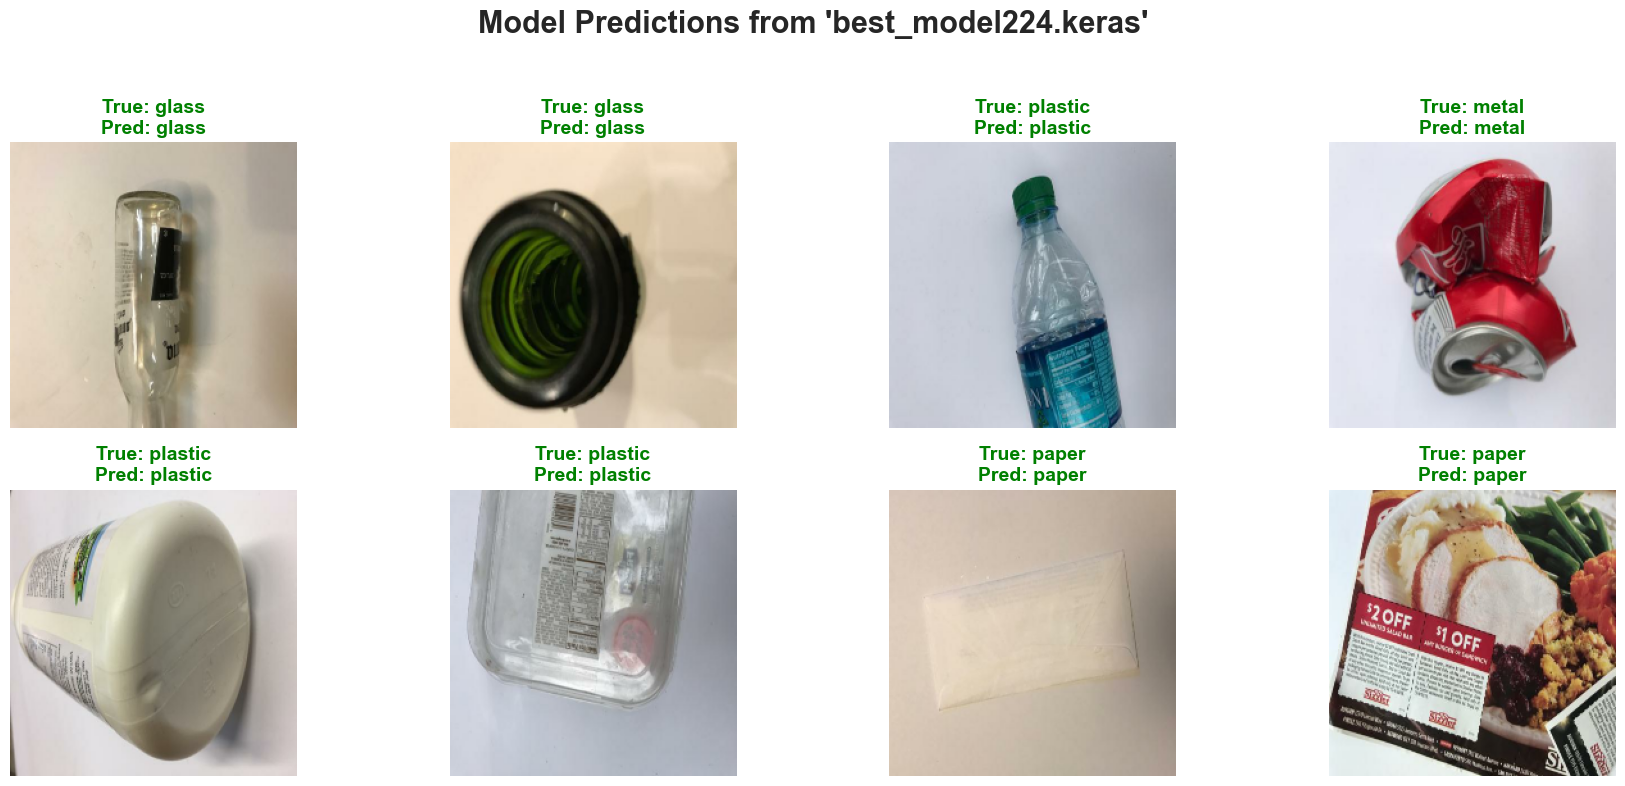

In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load your trained model
model_path = 'best_model224.keras'  # Change if needed
model = tf.keras.models.load_model(model_path)

# Get class names from training dataset
class_names = train_ds.class_names  

# Shuffle test dataset before sampling
test_ds_eval_shuffled = test_ds_eval.shuffle(1000, reshuffle_each_iteration=True)

# Take one random batch from test dataset and predict
for images, labels in test_ds_eval_shuffled.take(1):  
    predictions = model.predict(images)  
    pred_labels = tf.argmax(predictions, axis=1)

    # Plot first 8 images with predictions
    plt.figure(figsize=(18, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_cls = class_names[labels[i]]
        pred_cls = class_names[pred_labels[i]]
        
        # Green if correct, red if wrong
        title_color = 'green' if true_cls == pred_cls else 'red'
        plt.title(f"True: {true_cls}\nPred: {pred_cls}", color=title_color, fontsize=14, fontweight='bold')  # ← increased font size here
        plt.axis("off")
    
    plt.suptitle(f"Model Predictions from '{model_path}'", fontsize=22, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# 9 - Retraining Model

📏 Old Model Accuracy: 94.06%

🔁 Fine-Tuning EfficientNetV2B2 + Custom CNN...
🔓 Unfroze layers after 75
🎯 Previous Validation Accuracy: 94.06%
💾 Will save only if validation accuracy improves over previous



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.4263 - loss: 1.5145 - val_accuracy: 0.9050 - val_loss: 0.9807
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9139 - loss: 0.6805 - val_accuracy: 0.9228 - val_loss: 0.6108
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9466 - loss: 0.4859 - val_accuracy: 0.9347 - val_loss: 0.4357
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9478 - loss: 0.4016 - val_accuracy: 0.9386 - val_loss: 0.3706
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 252s 4s/step - accuracy: 0.9500 - loss: 0.3629 - val_accuracy: 0.9347 - val_loss: 0.3290
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9598 - loss: 0.3080 - val_accuracy: 0.9386 - val_loss: 0.2998
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9629 - loss: 0.2880
💾 Improved! New Val Acc: 0.9406 > Prev Best: 0.9406. Saving as 'best_model_finetuned224.keras'...
64/64 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.963

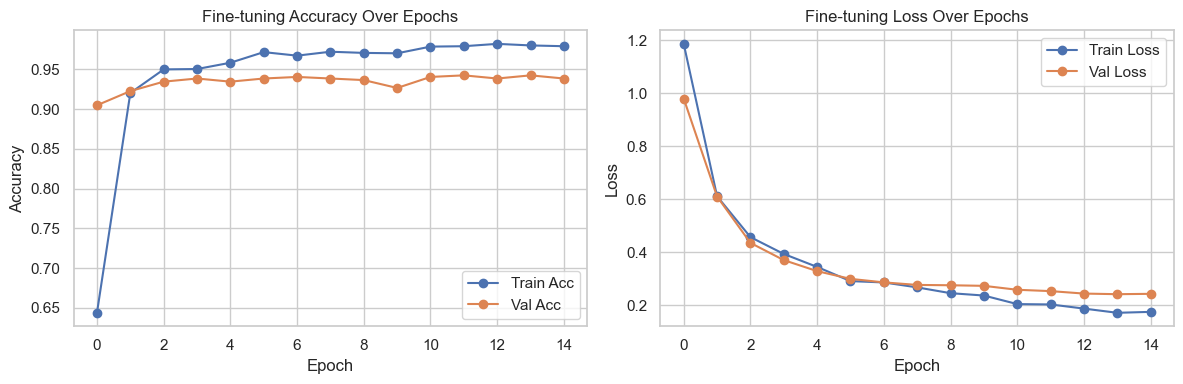

In [19]:
#  Retraining Pipeline with Accuracy Comparison and Conditional Saving + Custom CNN Layers

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers, models
from sklearn.metrics import accuracy_score
import pickle
import numpy as np

#  Load the previously saved model
old_model_path = 'best_model224.keras'
model_save_path = 'best_model_finetuned224.keras'

old_model = tf.keras.models.load_model(old_model_path)

#  Evaluate old model on validation set
val_images, val_labels = [], []
for x, y in val_ds.unbatch():
    val_images.append(x.numpy())
    val_labels.append(y.numpy())

val_images = np.stack(val_images)
val_labels = np.array(val_labels)

old_preds = old_model.predict(val_images, verbose=0)
old_pred_labels = np.argmax(old_preds, axis=1)
old_val_accuracy = accuracy_score(val_labels, old_pred_labels)
print(f"📏 Old Model Accuracy: {old_val_accuracy*100:.2f}%")

#  Extract the EfficientNetV2B2 base model from the saved model
base_model = None
for layer in old_model.layers:
    if isinstance(layer, tf.keras.Model) and 'efficientnet' in layer.name:
        base_model = layer
        break
if base_model is None:
    raise ValueError("EfficientNetV2B2 base model not found inside loaded model.")

#  Unfreeze some deeper layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:75]:
    layer.trainable = False

#  Create new model with added custom CNN layers
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(6, activation='softmax')
])

#  Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Custom callback to conditionally save improved models
class ConditionalSave(tf.keras.callbacks.Callback):
    def __init__(self, initial_best, filename):
        self.best_accuracy = initial_best
        self.filename = filename

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc and val_acc > self.best_accuracy:
            print(f"\n💾 Improved! New Val Acc: {val_acc:.4f} > Prev Best: {self.best_accuracy:.4f}. Saving as '{self.filename}'...")
            self.model.save(self.filename)
            self.best_accuracy = val_acc

#  Callbacks
early = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

#  Fine-tuning Info
epochs = 15
print("\n🔁 Fine-Tuning EfficientNetV2B2 + Custom CNN...")
print(f"🔓 Unfroze layers after 75")
print(f"🎯 Previous Validation Accuracy: {old_val_accuracy*100:.2f}%")
print(f"💾 Will save only if validation accuracy improves over previous\n")

#  Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[
        early,
        TqdmCallback(verbose=1),
        ConditionalSave(initial_best=old_val_accuracy, filename=model_save_path)
    ]
)

#  Save history
with open("history_finetuned224.pkl", "wb") as f:
    pickle.dump(history.history, f)

#  Show Log Table
df_log = pd.DataFrame(history.history)
print("\n📊 Fine-tuning Log Summary:")
print(df_log.to_string(index=True))

#  Plot Training Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Fine-tuning Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Fine-tuning Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# 10 - Evaluate Model Matrics

In [25]:
import tensorflow as tf
import pickle
import pandas as pd

# === Paths ===
model_path = 'best_model_finetuned224.keras'     
history_path = 'history_finetuned224.pkl'         

# === Load the model ===
model = tf.keras.models.load_model(model_path)
print(f"Loaded model from: {model_path}")


# === Load history ===
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# === Get final epoch metrics ===
final_accuracy     = history['accuracy'][-1]
final_val_accuracy = history['val_accuracy'][-1]
final_loss         = history['loss'][-1]
final_val_loss     = history['val_loss'][-1]

print("\n📊 Final Training Summary:")
print(f"Train Accuracy     : {final_accuracy:.4f}")
print(f"Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Train Loss         : {final_loss:.4f}")
print(f"Validation Loss    : {final_val_loss:.4f}")


Loaded model from: best_model_finetuned224.keras

📊 Final Training Summary:
Train Accuracy     : 0.9792
Validation Accuracy: 0.9386
Train Loss         : 0.1752
Validation Loss    : 0.2433


# 11 - Comparing Model Performance: Accuracy & Loss Trends

In [24]:
import matplotlib.pyplot as plt
import pickle

def plot_model_history(history_file, model_name="Model"):
    # Load training history from a .pkl file
    with open(history_file, "rb") as f:
        history = pickle.load(f)

    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs_range = range(len(acc))

    # Set up plots
    plt.figure(figsize=(12, 5))

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc', color='green', marker='o')
    plt.plot(epochs_range, val_acc, label='Val Acc', color='blue', marker='s', linestyle='--')
    plt.title(f'📈 Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower right')
    plt.xticks(epochs_range)

    # --- Loss Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='red', marker='o')
    plt.plot(epochs_range, val_loss, label='Val Loss', color='orange', marker='s', linestyle='--')
    plt.title(f'📉 Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')
    plt.xticks(epochs_range)

    # Layout & show
    plt.suptitle(f"📊 Training Summary for {model_name}", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_10856\3320950664.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10856\3320950664.py:42: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10856\3320950664.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\IPython\core

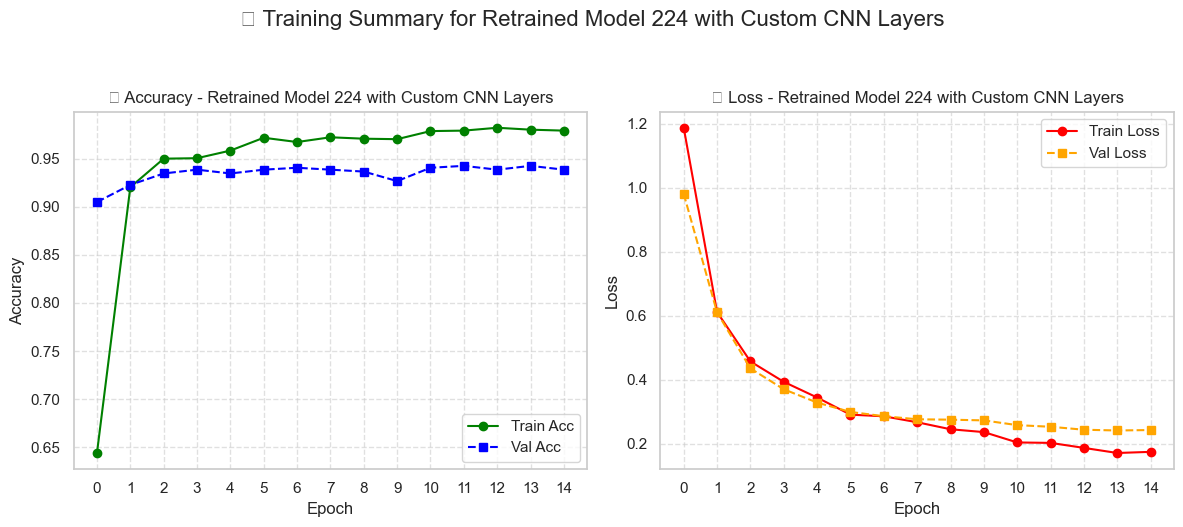

In [29]:
plot_model_history("history_finetuned224.pkl", model_name="Retrained Model 224 with Custom CNN Layers")


# 12 - Deployment

In [2]:
# Garbage Classification Flask Web Application
# Educational platform for waste management and AI model deployment
# Developed by Shanmugaraj

from flask import Flask, render_template, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import numpy as np
from PIL import Image
import io
import os
import threading
import time

# Initialize Flask application
app = Flask(__name__)

# Configure upload settings
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024  # 16MB max file size
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg', 'gif', 'bmp'}

# Load your trained model
try:
    model = load_model("best_model_finetuned224.keras")
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("⚠️  Make sure 'best_model_finetuned224.keras' is in the project directory")
    model = None

# Class labels matching your model
class_names = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

# Waste category information for educational content
waste_categories = [
    {
        "name": "Cardboard", 
        "description": "Boxes, packaging materials", 
        "icon": "📦",
        "examples": ["Shipping boxes", "Cereal boxes", "Pizza boxes"],
        "recyclable": True,
        "tips": "Remove tape and flatten boxes before recycling. Clean cardboard recycles better."
    },
    {
        "name": "Glass", 
        "description": "Bottles, jars, containers", 
        "icon": "🍶",
        "examples": ["Wine bottles", "Mason jars", "Glass containers"],
        "recyclable": True,
        "tips": "Remove lids and rinse clean. Clear glass has the highest recycling value."
    },
    {
        "name": "Metal", 
        "description": "Cans, foil, metal objects", 
        "icon": "🥫",
        "examples": ["Aluminum cans", "Tin foil", "Metal containers"],
        "recyclable": True,
        "tips": "Rinse food residue and remove labels when possible. Aluminum recycles infinitely."
    },
    {
        "name": "Paper", 
        "description": "Newspapers, magazines, documents", 
        "icon": "📄",
        "examples": ["Newspapers", "Office paper", "Magazines"],
        "recyclable": True,
        "tips": "Keep paper dry and clean. Remove staples and plastic windows from envelopes."
    },
    {
        "name": "Plastic", 
        "description": "Bottles, bags, containers", 
        "icon": "🧴",
        "examples": ["Water bottles", "Plastic bags", "Food containers"],
        "recyclable": True,
        "tips": "Check recycling number. Clean containers and remove caps. Not all plastics are recyclable."
    },
    {
        "name": "Trash", 
        "description": "Non-recyclable waste", 
        "icon": "🗑️",
        "examples": ["Food waste", "Contaminated items", "Mixed materials"],
        "recyclable": False,
        "tips": "Items too contaminated or made of mixed materials should go to regular trash."
    }
]

def allowed_file(filename):
    """Check if file extension is allowed"""
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def preprocess_image(image):
    """Preprocess image for model prediction"""
    try:
        # Resize image to model input size (224x224)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        image = image.resize((224, 224))
        img_array = np.array(image, dtype=np.float32)
        
        # Ensure correct shape
        if img_array.shape != (224, 224, 3):
            return None
        
        # Apply EfficientNetV2 preprocessing
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

@app.route('/')
def index():
    """Home page route - Educational content about garbage classification"""
    return render_template('index.html', 
                         categories=waste_categories,
                         model_available=model is not None)

@app.route('/model')
def model_page():
    """Model deployment page route - ML model interface"""
    return render_template('model.html', 
                         model_available=model is not None)

@app.route('/predict', methods=['POST'])
def predict():
    """Prediction endpoint - Process uploaded images and return classification results"""
    try:
        # Check if model is loaded
        if model is None:
            return jsonify({
                'success': False,
                'error': 'Model not loaded. Please ensure best_model_finetuned224.keras is in the project directory.'
            })
        
        # Check if file is in request
        if 'file' not in request.files:
            return jsonify({
                'success': False,
                'error': 'No file uploaded. Please select an image to classify.'
            })
        
        file = request.files['file']
        
        # Check if file is selected
        if file.filename == '':
            return jsonify({
                'success': False,
                'error': 'No file selected. Please choose an image file.'
            })
        
        # Check file extension
        if not allowed_file(file.filename):
            return jsonify({
                'success': False,
                'error': 'Invalid file type. Please upload PNG, JPG, JPEG, GIF, or BMP files only.'
            })
        
        # Read and process image
        image_data = file.read()
        image = Image.open(io.BytesIO(image_data))
        
        # Preprocess image for model
        processed_image = preprocess_image(image)
        if processed_image is None:
            return jsonify({
                'success': False,
                'error': 'Error processing image. Please try a different image.'
            })
        
        # Make prediction
        prediction = model.predict(processed_image, verbose=0)[0]
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]
        confidence = float(prediction[predicted_class_index])
        
        # Get category details
        category_info = next((cat for cat in waste_categories if cat['name'] == predicted_class_name), None)
        
        # Prepare response
        response = {
            'success': True,
            'prediction': predicted_class_name,
            'confidence': confidence,
            'confidence_percentage': f"{confidence:.1%}",
            'category_info': category_info,
            'all_predictions': [
                {
                    'class': class_names[i],
                    'confidence': float(prediction[i]),
                    'percentage': f"{float(prediction[i]):.1%}"
                }
                for i in range(len(class_names))
            ]
        }
        
        return jsonify(response)
        
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return jsonify({
            'success': False,
            'error': f'An error occurred during prediction: {str(e)}'
        })

@app.errorhandler(413)
def too_large(e):
    """Handle file too large error"""
    return jsonify({
        'success': False,
        'error': 'File too large. Please upload an image smaller than 16MB.'
    }), 413

@app.errorhandler(404)
def not_found(e):
    """Handle page not found error"""
    return render_template('index.html', categories=waste_categories), 404

@app.errorhandler(500)
def server_error(e):
    """Handle internal server error"""
    return jsonify({
        'success': False,
        'error': 'Internal server error. Please try again.'
    }), 500

def create_directories():
    """Create required directories if they don't exist"""
    directories = ['templates', 'static', 'static/images']
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"📁 Created directory: {directory}")

def run_flask_app():
    """Run Flask application in a separate thread"""
    # Use port 5001 since 5000 is occupied
    app.run(debug=False, use_reloader=False, host='0.0.0.0', port=5001, threaded=True)

def start_server():
    """Start the Flask server for Jupyter notebook"""
    print("🚀 GARBAGE CLASSIFICATION SERVER")
    print("=" * 50)
    
    # Create required directories
    create_directories()
    
    # System diagnostics
    print(f"📁 Current Directory: {os.getcwd()}")
    print(f"🧠 Model Status: {'✅ Loaded' if model is not None else '❌ Not Loaded'}")
    print(f"📄 Model File Exists: {'✅ Yes' if os.path.exists('best_model_finetuned224.keras') else '❌ No'}")
    
    print("\n🚀 Starting Flask Server on Port 5001...")
    print("⚠️  Using Port 5001 because Port 5000 is occupied")
    
    # Run Flask in a separate thread
    flask_thread = threading.Thread(target=run_flask_app, daemon=True)
    flask_thread.start()
    
    # Wait for server to start
    time.sleep(3)
    
    print("=" * 50)
    print("✅ SERVER STARTED SUCCESSFULLY!")
    print("🌐 Access your application:")
    print("   📚 Home Page: http://localhost:5001")
    print("   🤖 Model Page: http://localhost:5001/model")
    print("   🌐 Network Access: http://192.168.1.8:5001")
    print("\n💡 Make sure you have the following files/folders:")
    print("   📁 templates/ (folder)")
    print("   📁 static/ (folder)")  
    print("   🎯 best_model_finetuned224.keras (model file)")
    print("\n🛑 To stop: restart notebook kernel")
    print("=" * 50)
    
    return "Server running on port 5001!"

if __name__ == '__main__':
    try:
        # Check if running in Jupyter
        __IPYTHON__
        print("📓 Jupyter environment detected")
        print("🔧 Use: start_server()")
    except NameError:
        # Running from command line
        create_directories()
        print("💻 Running from command line on port 5001")
        app.run(debug=True, host='0.0.0.0', port=5001)

✅ Model loaded successfully!
📓 Jupyter environment detected
🔧 Use: start_server()


In [3]:
start_server()

🚀 GARBAGE CLASSIFICATION SERVER
📁 Current Directory: C:\Users\USER\Garbage Classification projects
🧠 Model Status: ✅ Loaded
📄 Model File Exists: ✅ Yes

🚀 Starting Flask Server on Port 5001...
⚠️  Using Port 5001 because Port 5000 is occupied
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://10.97.232.147:5001
Press CTRL+C to quit


✅ SERVER STARTED SUCCESSFULLY!
🌐 Access your application:
   📚 Home Page: http://localhost:5001
   🤖 Model Page: http://localhost:5001/model
   🌐 Network Access: http://192.168.1.8:5001

💡 Make sure you have the following files/folders:
   📁 templates/ (folder)
   📁 static/ (folder)
   🎯 best_model_finetuned224.keras (model file)

🛑 To stop: restart notebook kernel


'Server running on port 5001!'

10.97.232.147 - - [06/Oct/2025 12:49:42] "GET / HTTP/1.1" 200 -
10.97.232.147 - - [06/Oct/2025 12:49:43] "GET /static/style.css HTTP/1.1" 304 -
10.97.232.147 - - [06/Oct/2025 12:49:44] "GET /favicon.ico HTTP/1.1" 404 -
10.97.232.147 - - [06/Oct/2025 12:52:31] "GET /model HTTP/1.1" 200 -
10.97.232.147 - - [06/Oct/2025 12:52:31] "GET /static/style.css HTTP/1.1" 304 -
10.97.232.147 - - [06/Oct/2025 12:53:09] "POST /predict HTTP/1.1" 200 -
10.97.232.147 - - [06/Oct/2025 12:54:19] "POST /predict HTTP/1.1" 200 -
10.97.232.147 - - [06/Oct/2025 12:54:19] "POST /predict HTTP/1.1" 200 -
10.97.232.147 - - [06/Oct/2025 12:55:15] "GET / HTTP/1.1" 200 -
10.97.232.147 - - [06/Oct/2025 12:55:15] "GET /static/style.css HTTP/1.1" 304 -
